In [1]:
import sagemaker
import boto3
from sagemaker.session import s3_input, Session

In [2]:
bucket_name = 'supraja-arima-tesladataset' 
my_region = boto3.session.Session().region_name # set the region of the instance
print(my_region)

us-east-1


In [3]:
s3 = boto3.resource('s3')
try:
    if  my_region == 'us-east-1':
        s3.create_bucket(Bucket=bucket_name)
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)

S3 bucket created successfully


In [4]:
# set an output path where the trained model will be saved
prefix = 'arima-tesla-as-a-built-in-algo'
output_path ='s3://{}/{}/output'.format(bucket_name, prefix)
print(output_path)

s3://supraja-arima-tesladataset/arima-tesla-as-a-built-in-algo/output


In [5]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
symbol = ["TSLA"]
start_date = "2007-01-02"
features = yf.download(symbol, start=start_date)


[*********************100%***********************]  1 of 1 completed


In [7]:
# Drop multiple columns
features = features.drop(['Open', 'High','Low', 'Adj Close','Volume'], axis=1)

In [8]:
features

,Close
Date,
2010-06-29,1.592667
2010-06-30,1.588667
2010-07-01,1.464000
2010-07-02,1.280000
2010-07-06,1.074000
...,...
2023-07-27,255.710007
2023-07-28,266.440002
2023-07-31,267.429993


In [9]:
features = features.dropna(axis=0)
features.isna().sum()

Close    0
dtype: int64

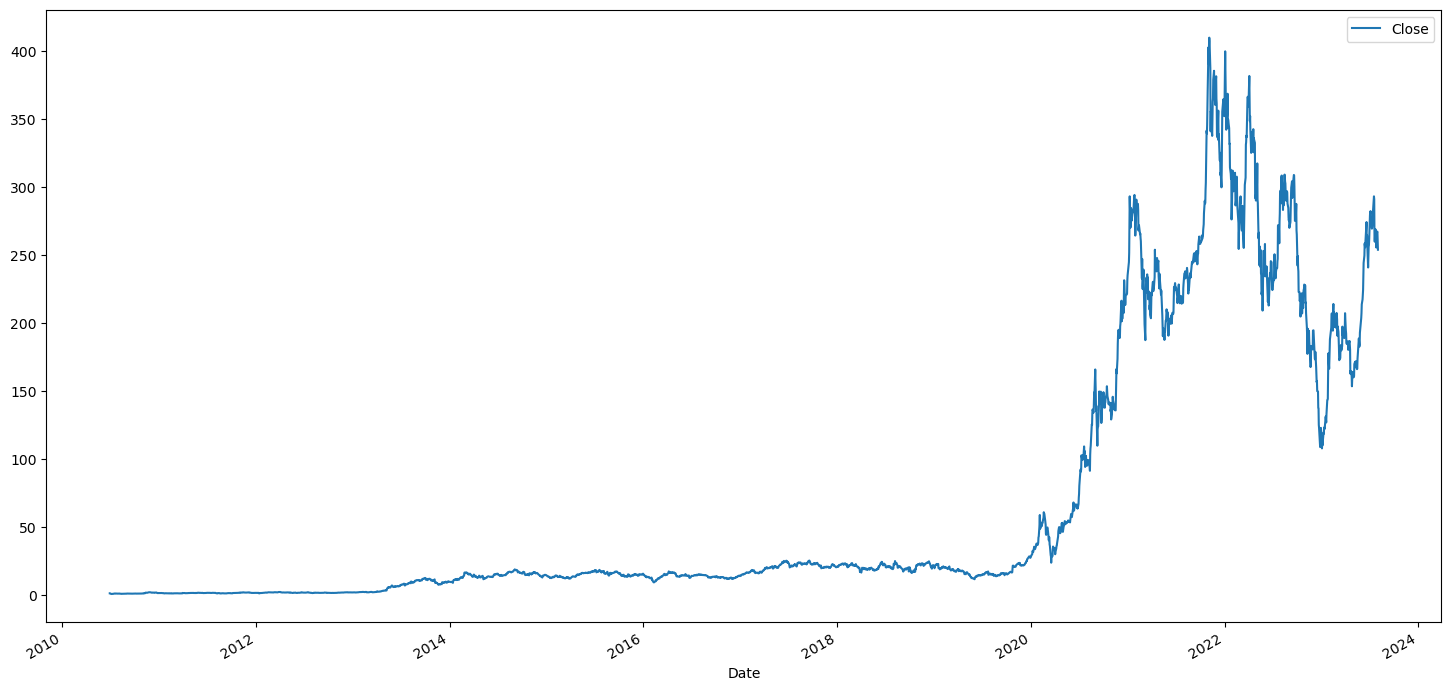

In [10]:
features_plot = pd.DataFrame(features, index=features.index)
# Plot the DataFrame
features_plot.plot(figsize=(18,9))
plt.show()

In [11]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


In [12]:
import pandas as pd
import numpy as np

In [13]:
df = features 
df.shape

(3296, 1)

In [14]:
from statsmodels.tsa.stattools import adfuller

def ad_test(dataset):
  dftest = adfuller(dataset, autolag = "AIC")
  print("1. ADF : " , dftest[0])
  print("2. P-value :" , dftest[1])
  print("3. Num of Lags :" , dftest[2])
  print("4. Num of Observations Used For ADF Regressor and Critical Value Calculations  :" , dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
    print("\t", key,": ", val)

In [15]:
ad_test(df["Close"])

1. ADF :  -0.8048470280064846
2. P-value : 0.8176941418388769
3. Num of Lags : 29
4. Num of Observations Used For ADF Regressor and Critical Value Calculations  : 3266
5. Critical Values :
	 1% :  -3.432353811104443
	 5% :  -2.862425364403165
	 10% :  -2.567241298246627


As from above test we see that the P-value is very high at 0.99 which states that the data is not staionary.

In [16]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [17]:
stepwise_fit = auto_arima(df["Close"], trace=True, suppress_warnings = True, stepwise=False, seasonal=False)
stepwise_fit.summary()

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19362.737, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19361.273, Time=0.62 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=19362.829, Time=0.90 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=19364.723, Time=1.62 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=19357.660, Time=1.62 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=19356.559, Time=2.92 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19361.194, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=19362.362, Time=2.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=19364.359, Time=2.72 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=19366.113, Time=1.88 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=19364.916, Time=3.96 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=19362.809, Time=0.55 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=19360.217, Time=2.65 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=19366.353, Time=2.35 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=19305.470, Time=8.02

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3296
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -9645.735
Date:                Thu, 03 Aug 2023   AIC                          19305.470
Time:                        04:37:35   BIC                          19348.171
Sample:                             0   HQIC                         19320.756
                               - 3296                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2281      0.224      1.019      0.308      -0.211       0.667
ar.L1         -1.0989      0.012    -94.070      0.000      -1.122      -1.076
ar.L2         -0.8671      0.013    -68.546      0.000      -0.892      -0.842
ma.L1          1.0843      0.014     80.280      0.000       1.058       1.111
ma.L2          0.8219      0.015     53.196      0.000       0.792       0.852
ma.L3         -0.0815      0.008     -9.822      0.000      -0.098      -0.065
sigma2        20.4256      0.157    130.318      0.000      20.118      20.733
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):             56714.80
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):             855.70   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
from statsmodels.tsa.arima_model import ARIMA

In [19]:
print(df.shape)
train = df.iloc[:-30]
test = df.iloc[-30:]
print(train.shape,test.shape)


(3296, 1)
(3266, 1) (30, 1)


In [20]:
import os
train_csv = train.to_csv('tesla-arima-train.csv')
test_csv = test.to_csv('tesla-arima-test.csv')

In [21]:
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train/apple-arima-train.csv')).upload_file('apple-arima-train.csv')
s3_input_train = sagemaker.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')

In [22]:
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'test/apple-arima-test.csv')).upload_file('apple-arima-test.csv')
s3_input_train = sagemaker.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')

In [23]:
train['Close']

Date
2010-06-29      1.592667
2010-06-30      1.588667
2010-07-01      1.464000
2010-07-02      1.280000
2010-07-06      1.074000
                 ...    
2023-06-13    258.709991
2023-06-14    256.790009
2023-06-15    255.899994
2023-06-16    260.540009
2023-06-20    274.450012
Name: Close, Length: 3266, dtype: float64

In [24]:
test["Close"].tail()

Date
2023-07-27    255.710007
2023-07-28    266.440002
2023-07-31    267.429993
2023-08-01    261.070007
2023-08-02    254.110001
Name: Close, dtype: float64

In [25]:
import statsmodels.api as sm
model = sm.tsa.arima.ARIMA(train["Close"], order=(2,1,3))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 3266
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -9540.325
Date:                Thu, 03 Aug 2023   AIC                          19092.649
Time:                        04:37:39   BIC                          19129.195
Sample:                             0   HQIC                         19105.738
                               - 3266                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0327      0.073     -0.450      0.653      -0.175       0.110
ar.L2          0.7488      0.068     11.088      0.000       0.616       0.881
ma.L1         -0.0021      0.072     -0.029      0.977      -0.143       0.139
ma.L2         -0.7351      0.069    -10.659      0.000      -0.870      -0.600
ma.L3          0.0639      0.008      7.840      0.000       0.048       0.080
sigma2        20.2092      0.146    138.298      0.000      19.923      20.496
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             68381.45
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             969.00   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
start = len(train)
end = len(train)+len(test)-1
pred = model.predict(start=start,end=end,typ='levels')
pred.index = df.index[start:end+1]
print(pred)

Date
2023-06-21    274.636667
2023-06-22    275.393052
2023-06-23    276.368125
2023-06-26    276.902697
2023-06-27    277.615419
2023-06-28    277.992454
2023-06-29    278.513860
2023-06-30    278.779173
2023-07-03    279.160962
2023-07-05    279.347172
2023-07-06    279.626991
2023-07-07    279.757295
2023-07-10    279.962582
2023-07-11    280.053455
2023-07-12    280.204215
2023-07-13    280.267342
2023-07-14    280.378177
2023-07-17    280.421829
2023-07-18    280.503402
2023-07-19    280.533426
2023-07-20    280.593531
2023-07-21    280.614052
2023-07-24    280.658391
2023-07-25    280.672310
2023-07-26    280.705059
2023-07-27    280.714413
2023-07-28    280.738631
2023-07-31    280.744844
2023-08-01    280.762777
2023-08-02    280.766845
Name: predicted_mean, dtype: float64


In [27]:
pred_csv=pred.to_csv('pred-tesla.csv')

<Axes: xlabel='Date'>

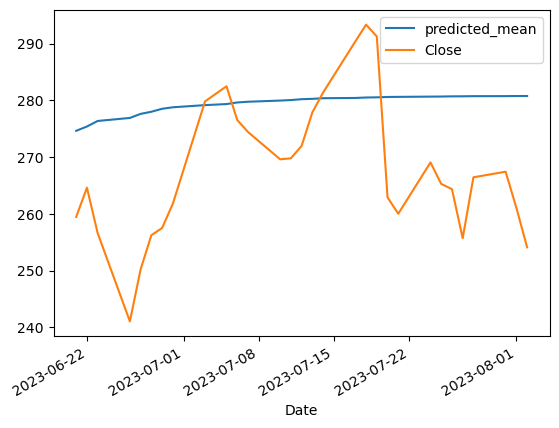

In [28]:
pred.plot(legend=True)
test["Close"].plot(legend=True)

In [29]:
from sklearn.metrics import mean_squared_error 
from math import sqrt
rmse = sqrt(mean_squared_error(pred,test["Close"]))
print(rmse)

16.50569417622156


In [30]:
test["Close"].mean()

267.757666015625

In [31]:
model2 = sm.tsa.arima.ARIMA(train["Close"], order=(2,1,3))
model2 = model2.fit()


In [32]:
train["Close"]

Date
2010-06-29      1.592667
2010-06-30      1.588667
2010-07-01      1.464000
2010-07-02      1.280000
2010-07-06      1.074000
                 ...    
2023-06-13    258.709991
2023-06-14    256.790009
2023-06-15    255.899994
2023-06-16    260.540009
2023-06-20    274.450012
Name: Close, Length: 3266, dtype: float64

Fututre predictions

In [33]:
future_index=pd.date_range(start="2023-05-04", end = "2023-06-02")
pred = model2.predict(start = len(df),end=len(df)+29,typ='levels').rename('ARIMA Prdictions')
pred.index = future_index

In [34]:
pred

2023-05-04    280.780141
2023-05-05    280.782752
2023-05-06    280.792624
2023-05-07    280.794257
2023-05-08    280.801596
2023-05-09    280.802579
2023-05-10    280.808043
2023-05-11    280.808601
2023-05-12    280.812674
2023-05-13    280.812959
2023-05-14    280.816000
2023-05-15    280.816114
2023-05-16    280.818387
2023-05-17    280.818398
2023-05-18    280.820100
2023-05-19    280.820053
2023-05-20    280.821329
2023-05-21    280.821252
2023-05-22    280.822210
2023-05-23    280.822121
2023-05-24    280.822841
2023-05-25    280.822751
2023-05-26    280.823294
2023-05-27    280.823208
2023-05-28    280.823617
2023-05-29    280.823540
2023-05-30    280.823849
2023-05-31    280.823781
2023-06-01    280.824015
2023-06-02    280.823956
Freq: D, Name: ARIMA Prdictions, dtype: float64

In [35]:
output=pred.to_csv('tesla-arima-output.csv')


In [36]:
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'output/tesla-arima-output.csv')).upload_file('tesla-arima-output.csv')
s3_input_train = sagemaker.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')

In [37]:
# Calculate RMSE, MAPE, and MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from math import sqrt
rmse = sqrt(mean_squared_error(pred,test["Close"]))
mape = np.mean(np.abs((test["Close"] - pred) / test["Close"])) * 100
mae = mean_absolute_error(pred, test["Close"])

# Print metrics
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')
print(f'MAE: {mae:.2f}')


RMSE: 17.89
MAPE: nan%
MAE: 15.37
